In [1]:
import numpy as np 
import pandas as pd 

from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)

In [2]:
# Read CSV train data file into DataFrame
train_df = pd.read_csv("titanic/train.csv")

# Read CSV test data file into DataFrame
test_df = pd.read_csv("titanic/test.csv")

# preview train data
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
print('The number of samples into the train data is {}.'.format(train_df.shape[0]))

The number of samples into the train data is 891.


In [4]:
# preview test data
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
print('The number of samples into the test data is {}.'.format(test_df.shape[0]))

The number of samples into the test data is 418.


Note: there is no target variable into test data (i.e. "Survival" column is missing), so the goal is to predict this target using different machine learning algorithms such as logistic regression.

In [6]:
# check missing values in train data
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
# percent of missing "Age" 
print('Percent of missing "Age" records is %.2f%%' %((train_df['Age'].isnull().sum()/train_df.shape[0])*100))

Percent of missing "Age" records is 19.87%


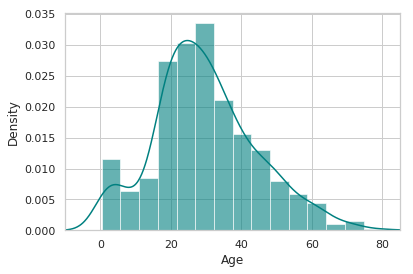

In [8]:
ax = train_df["Age"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
train_df["Age"].plot(kind='density', color='teal')
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()

Since "Age" is (right) skewed, using the mean might give us biased results by filling in ages that are older than desired. To deal with this, we'll use the median to impute the missing values.

In [9]:
# mean age
print('The mean of "Age" is %.2f' %(train_df["Age"].mean(skipna=True)))
# median age
print('The median of "Age" is %.2f' %(train_df["Age"].median(skipna=True)))

The mean of "Age" is 29.70
The median of "Age" is 28.00


In [10]:
# percent of missing "Cabin" 
print('Percent of missing "Cabin" records is %.2f%%' %((train_df['Cabin'].isnull().sum()/train_df.shape[0])*100))

Percent of missing "Cabin" records is 77.10%


77% of records are missing, which means that imputing information and using this variable for prediction is probably not wise. We'll ignore this variable in our model.

In [11]:
# percent of missing "Embarked" 
print('Percent of missing "Embarked" records is %.2f%%' %((train_df['Embarked'].isnull().sum()/train_df.shape[0])*100))

Percent of missing "Embarked" records is 0.22%


Boarded passengers grouped by port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton):
S    644
C    168
Q     77
Name: Embarked, dtype: int64


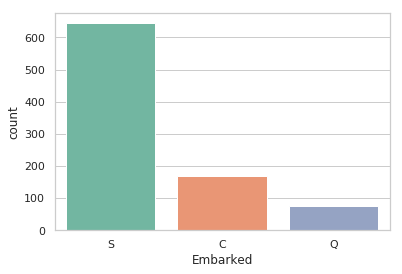

In [12]:
print('Boarded passengers grouped by port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton):')
print(train_df['Embarked'].value_counts())
sns.countplot(x='Embarked', data=train_df, palette='Set2')
plt.show()

In [13]:
print('The most common boarding port of embarkation is %s.' %train_df['Embarked'].value_counts().idxmax())

The most common boarding port of embarkation is S.


In [14]:
# Fill in the missing values
train_data = train_df.copy()
train_data["Age"].fillna(train_df["Age"].median(skipna=True), inplace=True)
train_data["Embarked"].fillna(train_df['Embarked'].value_counts().idxmax(), inplace=True)
train_data.drop('Cabin', axis=1, inplace=True)

In [15]:
# check missing values in adjusted train data
train_data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

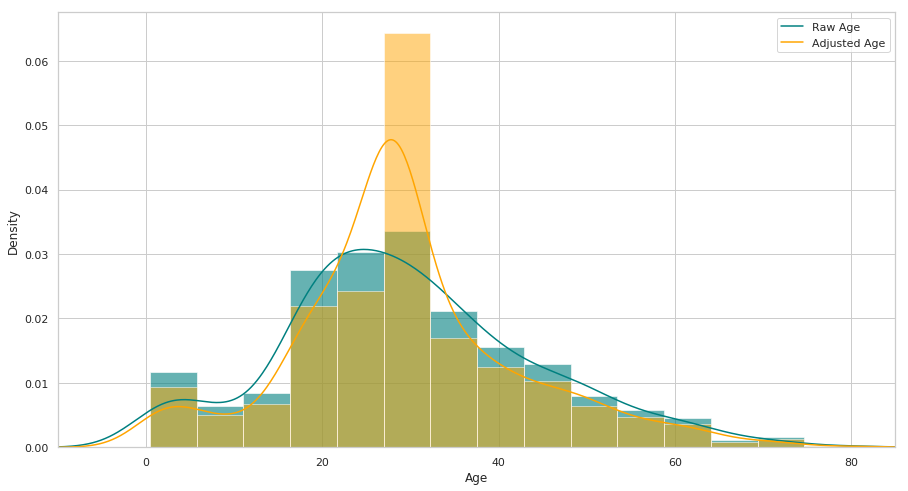

In [16]:


plt.figure(figsize=(15,8))
ax = train_df["Age"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
train_df["Age"].plot(kind='density', color='teal')
ax = train_data["Age"].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.5)
train_data["Age"].plot(kind='density', color='orange')
ax.legend(['Raw Age', 'Adjusted Age'])
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()



According to the Kaggle data dictionary, both SibSp and Parch relate to traveling with family. For simplicitys sake (and to account for possible multicollinearity), I'll combine the effect of these variables into one categorical predictor: whether or not that individual was traveling alone.

In [20]:
## Create categorical variable for traveling alone
train_data['TravelAlone']=np.where((train_data["SibSp"]+train_data["Parch"])>0, 0, 1)
train_data.drop('SibSp', axis=1, inplace=True)
train_data.drop('Parch', axis=1, inplace=True)



I'll also create categorical variables for Passenger Class ("Pclass"), Gender ("Sex"), and Port Embarked ("Embarked").


In [21]:


#create categorical variables and drop some variables
training=pd.get_dummies(train_data, columns=["Pclass","Embarked","Sex"])
training.drop('Sex_female', axis=1, inplace=True)
training.drop('PassengerId', axis=1, inplace=True)
training.drop('Name', axis=1, inplace=True)
training.drop('Ticket', axis=1, inplace=True)

final_train = training
final_train.head()



,Survived,Age,Fare,TravelAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_male
0,0,22.0,7.2500,0,0,0,1,0,0,1,1
1,1,38.0,71.2833,0,1,0,0,1,0,0,0
2,1,26.0,7.9250,1,0,0,1,0,0,1,0
3,1,35.0,53.1000,0,1,0,0,0,0,1,0
4,0,35.0,8.0500,1,0,0,1,0,0,1,1


### Test data

In [22]:
test_df.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [23]:


test_data = test_df.copy()
test_data["Age"].fillna(train_df["Age"].median(skipna=True), inplace=True)
test_data["Fare"].fillna(train_df["Fare"].median(skipna=True), inplace=True)
test_data.drop('Cabin', axis=1, inplace=True)

test_data['TravelAlone']=np.where((test_data["SibSp"]+test_data["Parch"])>0, 0, 1)

test_data.drop('SibSp', axis=1, inplace=True)
test_data.drop('Parch', axis=1, inplace=True)

testing = pd.get_dummies(test_data, columns=["Pclass","Embarked","Sex"])
testing.drop('Sex_female', axis=1, inplace=True)
testing.drop('PassengerId', axis=1, inplace=True)
testing.drop('Name', axis=1, inplace=True)
testing.drop('Ticket', axis=1, inplace=True)

final_test = testing
final_test.head()



,Age,Fare,TravelAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_male
0,34.5,7.8292,1,0,0,1,0,1,0,1
1,47.0,7.0000,0,0,0,1,0,0,1,0
2,62.0,9.6875,1,0,1,0,0,1,0,1
3,27.0,8.6625,1,0,0,1,0,0,1,1
4,22.0,12.2875,0,0,0,1,0,0,1,0


### Exploration of Age

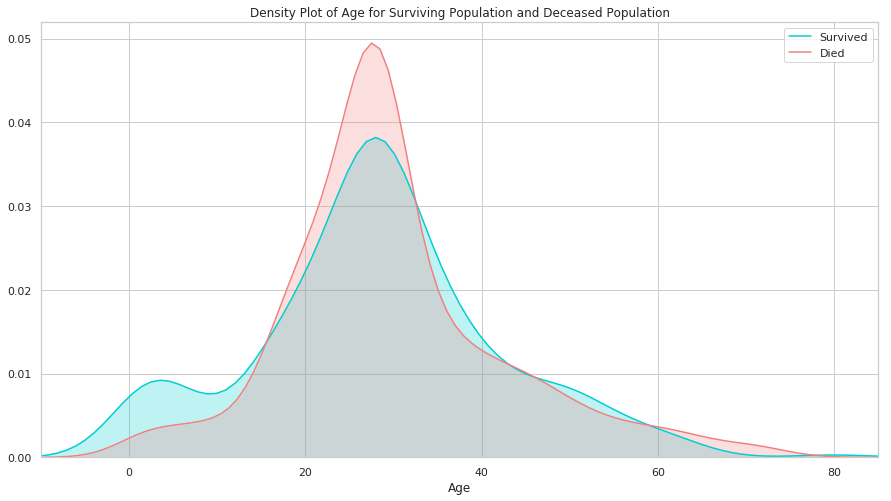

In [24]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(final_train["Age"][final_train.Survived == 1], color="darkturquoise", shade=True)
sns.kdeplot(final_train["Age"][final_train.Survived == 0], color="lightcoral", shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Age for Surviving Population and Deceased Population')
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()

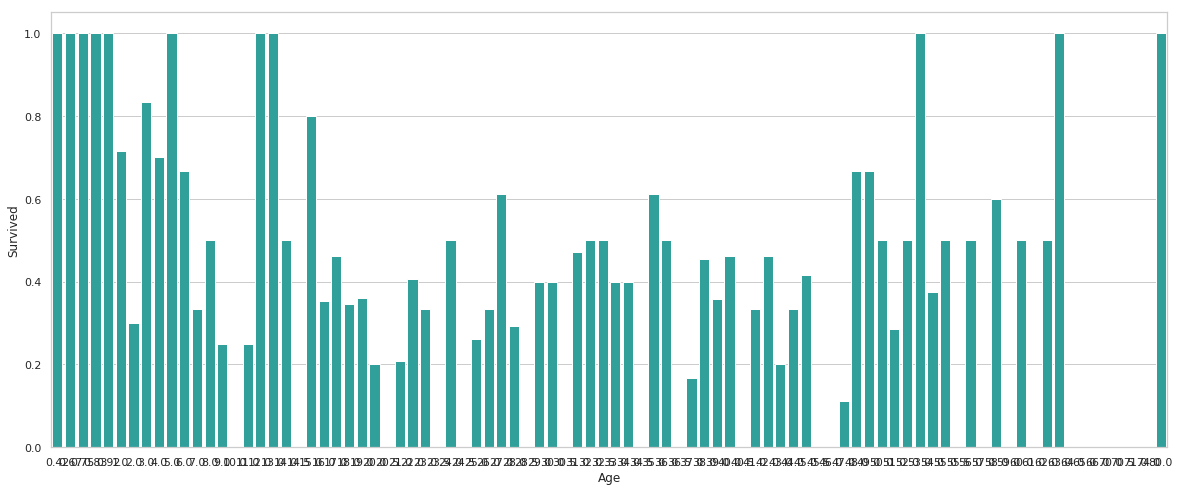

In [25]:
plt.figure(figsize=(20,8))
avg_survival_byage = final_train[["Age", "Survived"]].groupby(['Age'], as_index=False).mean()
g = sns.barplot(x='Age', y='Survived', data=avg_survival_byage, color="LightSeaGreen")
plt.show()

Considering the survival rate of passengers under 16, I'll also include another categorical variable in my dataset: "Minor"

In [28]:


final_train['IsMinor']=np.where(final_train['Age']<=16, 1, 0)

final_test['IsMinor']=np.where(final_test['Age']<=16, 1, 0)



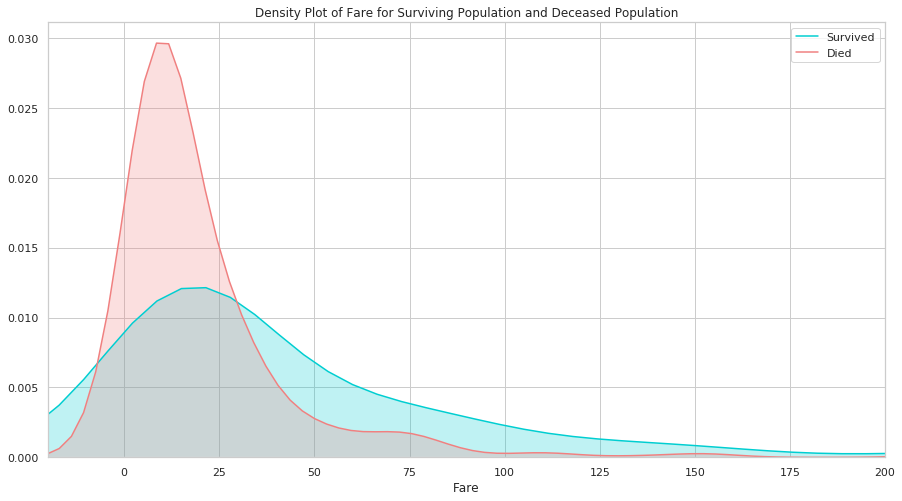

In [29]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(final_train["Fare"][final_train.Survived == 1], color="darkturquoise", shade=True)
sns.kdeplot(final_train["Fare"][final_train.Survived == 0], color="lightcoral", shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Fare for Surviving Population and Deceased Population')
ax.set(xlabel='Fare')
plt.xlim(-20,200)
plt.show()



As the distributions are clearly different for the fares of survivors vs. deceased, it's likely that this would be a significant predictor in our final model. Passengers who paid lower fare appear to have been less likely to survive. This is probably strongly correlated with Passenger Class, which we'll look at next.


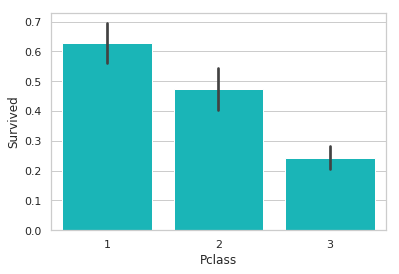

In [30]:


sns.barplot('Pclass', 'Survived', data=train_df, color="darkturquoise")
plt.show()



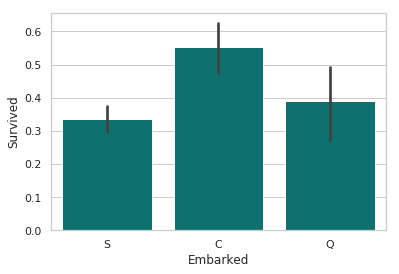

In [31]:


sns.barplot('Embarked', 'Survived', data=train_df, color="teal")
plt.show()





Passengers who boarded in Cherbourg, France, appear to have the highest survival rate. Passengers who boarded in Southhampton were marginally less likely to survive than those who boarded in Queenstown. This is probably related to passenger class, or maybe even the order of room assignments (e.g. maybe earlier passengers were more likely to have rooms closer to deck).
It's also worth noting the size of the whiskers in these plots. Because the number of passengers who boarded at Southhampton was highest, the confidence around the survival rate is the highest. The whisker of the Queenstown plot includes the Southhampton average, as well as the lower bound of its whisker. It's possible that Queenstown passengers were equally, or even more, ill-fated than their Southhampton counterparts.


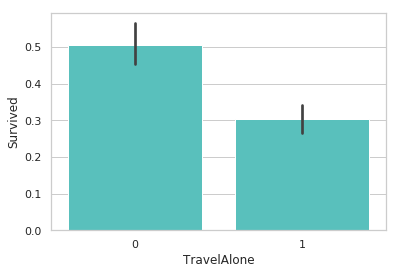

In [33]:
sns.barplot('TravelAlone', 'Survived', data=final_train, color="mediumturquoise")
plt.show()

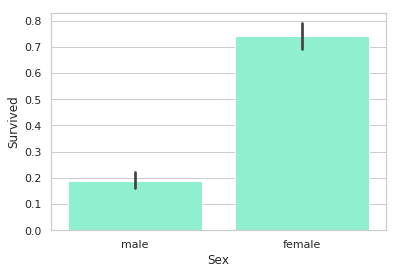

In [34]:
sns.barplot('Sex', 'Survived', data=train_df, color="aquamarine")
plt.show()

In [36]:

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss


# create X (features) and y (response)
X = final_train[cols]
y = final_train['Survived']

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [ ]:

# use train/test split with different random_state values
# we can change the random_state values that changes the accuracy scores
# the scores change a lot, this is why testing scores is a high-variance estimate
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [ ]:
# check classification scores of logistic regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

In [ ]:
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]

In [41]:

[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)
print('Train/Test split results:')
print(logreg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
print(logreg.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test, y_pred_proba))
print(logreg.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

Train/Test split results:
LogisticRegression accuracy is 0.765
LogisticRegression log_loss is 0.505
LogisticRegression auc is 0.838


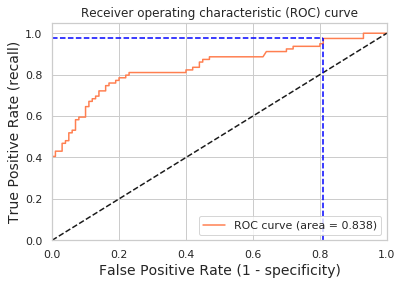

Using a threshold of 0.071 guarantees a sensitivity of 0.975 and a specificity of 0.190, i.e. a false positive rate of 81.00%.


In [42]:
idx = np.min(np.where(tpr > 0.95)) # index of the first threshold for which the sensibility > 0.95

plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

print("Using a threshold of %.3f " % thr[idx] + "guarantees a sensitivity of %.3f " % tpr[idx] +  
      "and a specificity of %.3f" % (1-fpr[idx]) + 
      ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))

### Can we do better?
- Recursive feature elimination
- Hyperparameter tuning
- Other classifiers (SVM, MLP)

### How about another dataset? (Iris)

In [43]:
from sklearn.datasets import load_iris
iris_dataset = load_iris()